In [1]:
#To execute on Google Colab
!pip install pm4py
!wget https://data.4tu.nl/ndownloader/files/24025820
!mv 24025820 BPI_Challenge_2018.xes.gz
!gzip -d BPI_Challenge_2018.xes.gz


     |████████████████████████████████| 1.4MB 6.6MB/s 
     |████████████████████████████████| 40.6MB 190kB/s 
  Created wheel for stringdist: filename=StringDist-1.0.9-cp37-cp37m-linux_x86_64.whl size=23556 sha256=05a38344a693461dae306c6beaa70accadf6258f67dff11f4c79bc88cc1194f9
  Stored in directory: /root/.cache/pip/wheels/c3/1b/bb/bf0de4d64d8ca38759811fe3353e441f12feb606fb3d1d2e11
Successfully built stringdist
--2021-06-06 03:06:41--  https://data.4tu.nl/ndownloader/files/24025820
Resolving data.4tu.nl (data.4tu.nl)... 131.180.141.6
Connecting to data.4tu.nl (data.4tu.nl)|131.180.141.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/gzip]
Saving to: ‘24025820’

24025820                [   <=>              ] 150.94M  28.9MB/s    in 6.1s    

2021-06-06 03:06:48 (24.7 MB/s) - ‘24025820’ saved [158270992]



In [2]:
from pm4py.objects.log.importer.xes import importer as xes_importer
import pm4py
import time
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model 
import tensorflow.keras.utils as ku 
import keras.backend as K
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm
from datetime import datetime
from pm4py.algo.filtering.log.timestamp import timestamp_filter
import math
from dateutil.relativedelta import *


In [3]:
# log = xes_importer.apply('filtered_log.xes')
# log = xes_importer.apply('financial_log-filtered-5.xes')
# log = xes_importer.apply('SuncorpSkin.xes')
log = xes_importer.apply('BPI_Challenge_2018.xes')


In [4]:
sizes_dict = {}
for i in range(len(log)):
    k = len(log[i])
    if k in sizes_dict:
        v = sizes_dict[k] 
        sizes_dict[k] = v + 1
    else:
        sizes_dict[k] = 1
print(sizes_dict)

{52: 1483, 50: 1319, 53: 1174, 47: 1934, 67: 350, 61: 641, 43: 1839, 54: 1654, 40: 1064, 44: 1605, 60: 620, 68: 315, 78: 165, 48: 1543, 42: 2016, 112: 46, 41: 2240, 72: 236, 51: 1215, 84: 157, 131: 16, 91: 98, 82: 166, 118: 44, 95: 78, 75: 235, 121: 22, 81: 149, 74: 209, 55: 1042, 45: 2186, 46: 1765, 49: 2949, 63: 395, 85: 144, 56: 767, 79: 193, 39: 1424, 137: 17, 150: 16, 87: 105, 94: 76, 69: 269, 62: 472, 117: 33, 127: 21, 57: 730, 102: 57, 76: 211, 213: 3, 148: 11, 89: 109, 111: 44, 59: 734, 157: 11, 66: 440, 73: 307, 80: 144, 71: 228, 65: 355, 97: 79, 569: 1, 119: 31, 83: 168, 93: 76, 108: 36, 58: 703, 103: 59, 64: 410, 70: 231, 133: 17, 106: 49, 77: 237, 122: 30, 38: 339, 188: 6, 114: 49, 125: 25, 105: 48, 90: 100, 146: 19, 138: 15, 100: 70, 104: 62, 86: 122, 143: 18, 181: 9, 110: 38, 135: 18, 113: 45, 186: 4, 252: 2, 98: 76, 228: 4, 115: 49, 180: 6, 107: 44, 136: 21, 88: 115, 169: 9, 101: 49, 124: 30, 116: 54, 196: 5, 140: 19, 344: 2, 37: 640, 96: 77, 92: 95, 197: 5, 128: 25, 149

In [5]:
print('Number of actions: ', len(sizes_dict))
print('Number of examples: ', len(log))


Number of actions:  339
Number of examples:  43809


In [6]:
vocab_index = {}
vocab_index['__'] = 0
for seq in log:
    for action in seq:
        action_name = action['concept:name']
        if not action_name in vocab_index:
            v = len(vocab_index)
            vocab_index[action_name] = v   

vocab_index['<sos>'] = len(vocab_index)
vocab_index['<eos>'] = len(vocab_index)


total_words = len(vocab_index)
print(vocab_index)

{'__': 0, 'mail income': 1, 'mail valid': 2, 'initialize': 3, 'begin editing': 4, 'finish editing': 5, 'save': 6, 'insert document': 7, 'performed': 8, 'calculate': 9, 'decide': 10, 'begin payment': 11, 'abort payment': 12, 'finish payment': 13, 'revoke decision': 14, 'check': 15, 'remove document': 16, 'plan': 17, 'finish preparations': 18, 'begin preparations': 19, 'prepare external': 20, 'abort external': 21, 'prepare offline': 22, 'performed offline': 23, 'withdraw': 24, 'revoke withdrawal': 25, 'begin admissibility check': 26, 'check admissibility': 27, 'approve': 28, 'take original document': 29, 'refuse': 30, 'begin editing from refused': 31, 'revoke approval': 32, 'discard': 33, 'cancel offline': 34, 'change department': 35, 'create': 36, 'restart editing': 37, 'finish pre-check': 38, 'calculate protocol': 39, 'clear': 40, 'correction GFM17': 41, '<sos>': 42, '<eos>': 43}


In [49]:
def get_data_with_filter(filtered_log, time_s, time_e):
  if type(time_s) is str or type(time_e) is str:
    timestamp_s = datetime.timestamp(datetime.strptime(time_s, '%Y-%m-%d %H:%M:%S'))
    timestamp_e = datetime.timestamp(datetime.strptime(time_e, '%Y-%m-%d %H:%M:%S'))
  else:
    timestamp_s = datetime.timestamp(time_s)
    timestamp_e = datetime.timestamp(time_e)
  input_sequences = []
  for seq in filtered_log:
      sequence = []
      timestamp = 0.0
      for action in seq:
          action_name = action['concept:name']        
          action_index = vocab_index[action_name]
          timestamp = datetime.timestamp(action["time:timestamp"])

          if timestamp >= timestamp_s and timestamp <= timestamp_e: 
            sequence.append((action_index, timestamp)) 
      if len(sequence) != 0: 
        sequence.sort(key=lambda x: x[1], reverse=False)
        
        sequence = [x[0] for x in sequence]     
        for i in range(1, len(sequence)):
                input_sequences.append(sequence[:i+1])          
  return input_sequences


input_sequences_train = get_data_with_filter(log, "2015-12-09 00:00:00", "2017-01-1 00:00:00")
input_sequences_val = get_data_with_filter(log, "2017-01-1 00:00:01", "2017-03-1 00:00:00")

print('Training size = ', len(input_sequences_train))
print('Val size = ', len(input_sequences_val))



Training size =  845690
Val size =  24686


In [48]:
start = datetime.strptime("2017-03-1 00:00:00", '%Y-%m-%d %H:%M:%S')
end = datetime.strptime("2018-01-19 23:59:59", '%Y-%m-%d %H:%M:%S')
input_sequences_test = []
while start < end:
  print(start)
  input_sequences_test.append(get_data_with_filter(log, start, start + relativedelta(weeks=+1)))
  start = start + relativedelta(days=+2)

2017-03-01 00:00:00
2017-03-03 00:00:00
2017-03-05 00:00:00
2017-03-07 00:00:00
2017-03-09 00:00:00
2017-03-11 00:00:00
2017-03-13 00:00:00
2017-03-15 00:00:00
2017-03-17 00:00:00
2017-03-19 00:00:00
2017-03-21 00:00:00
2017-03-23 00:00:00
2017-03-25 00:00:00
2017-03-27 00:00:00
2017-03-29 00:00:00
2017-03-31 00:00:00
2017-04-02 00:00:00
2017-04-04 00:00:00
2017-04-06 00:00:00
2017-04-08 00:00:00
2017-04-10 00:00:00
2017-04-12 00:00:00
2017-04-14 00:00:00
2017-04-16 00:00:00
2017-04-18 00:00:00
2017-04-20 00:00:00
2017-04-22 00:00:00
2017-04-24 00:00:00
2017-04-26 00:00:00
2017-04-28 00:00:00
2017-04-30 00:00:00
2017-05-02 00:00:00
2017-05-04 00:00:00
2017-05-06 00:00:00
2017-05-08 00:00:00
2017-05-10 00:00:00
2017-05-12 00:00:00
2017-05-14 00:00:00
2017-05-16 00:00:00
2017-05-18 00:00:00
2017-05-20 00:00:00
2017-05-22 00:00:00
2017-05-24 00:00:00
2017-05-26 00:00:00
2017-05-28 00:00:00
2017-05-30 00:00:00
2017-06-01 00:00:00
2017-06-03 00:00:00
2017-06-05 00:00:00
2017-06-07 00:00:00


Text(0, 0.5, '#of examples')

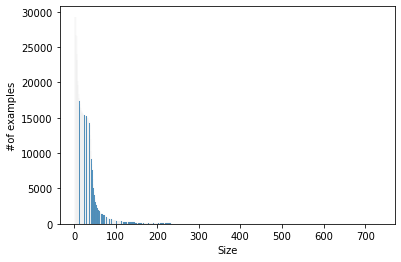

In [50]:
size_dist = []
for seq in input_sequences_train:
    size_dist.append(len(seq))

sns.histplot(size_dist)
plt.xlabel('Size')
plt.ylabel('#of examples')
# plt.xlim(0,200)


In [51]:
max_sequence_len = 50

In [52]:
sample = 20
reverse_vocab_index = dict(map(reversed, vocab_index.items()))
print("The entry ",sample," in 'input_sequences' is: ")
print(input_sequences_train[sample])
print(" and it corresponds to:")
for i in input_sequences_train[sample]:
    print(reverse_vocab_index[i], end=' ')
                        

The entry  20  in 'input_sequences' is: 
[11, 12, 11, 12, 11, 6, 6, 15]
 and it corresponds to:
begin payment abort payment begin payment abort payment begin payment save save check 

In [53]:
input_sequences_train2 = [ [vocab_index['<sos>']] + x for x in input_sequences_train]
output_sequences_train = [ x + [vocab_index['<eos>']] for x in input_sequences_train]
input_sequences_train = input_sequences_train2

input_sequences_val2 = [ [vocab_index['<sos>']] + x for x in input_sequences_val]
output_sequences_val = [ x + [vocab_index['<eos>']] for x in input_sequences_val]
input_sequences_val = input_sequences_val2


input_sequences_test_list = []
output_sequences_test_list = []
for e in input_sequences_test:
  input_sequences_test2 = [ [vocab_index['<sos>']] + x for x in e]
  output_sequences_test = [ x + [vocab_index['<eos>']] for x in e]

  input_sequences_test_list.append(input_sequences_test2)
  output_sequences_test_list.append(output_sequences_test)



Next, we padd our training set to the max length in order to be able to make a batch processing.

In [54]:
input_sequences_train = np.array(pad_sequences(input_sequences_train, maxlen=max_sequence_len, padding='pre'))
output_sequences_train = np.array(pad_sequences(output_sequences_train, maxlen=max_sequence_len, padding='pre'))


input_sequences_val = np.array(pad_sequences(input_sequences_val, maxlen=max_sequence_len, padding='pre'))
output_sequences_val = np.array(pad_sequences(output_sequences_val, maxlen=max_sequence_len, padding='pre'))


input_sequences_test_list_paded = []
output_sequences_test_list_paded = []

for e in input_sequences_test_list:
  input_sequences_test = np.array(pad_sequences(e, maxlen=max_sequence_len, padding='pre'))
  input_sequences_test_list_paded.append(input_sequences_test)

for e in output_sequences_test_list:
  output_sequences_test = np.array(pad_sequences(e, maxlen=max_sequence_len, padding='pre'))
  output_sequences_test_list_paded.append(output_sequences_test)






Run the following to see the containt of the padded 'input_sequences' object.

In [55]:
print("The entry ",sample," in 'input_sequences' is: ")
print(input_sequences_train[sample])
print(" and it corresponds to:")
print("[", end=' ')
for i in input_sequences_train[sample]:
  print(reverse_vocab_index[i], end=' ')
print("]")

print("The entry ",sample," in 'input_sequences' is: ")
print(output_sequences_train[sample])
print(" and it corresponds to:")
print("[", end=' ')
for i in output_sequences_train[sample]:
  print(reverse_vocab_index[i], end=' ')    
print("]")


The entry  20  in 'input_sequences' is: 
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 42 11 12 11 12 11  6
  6 15]
 and it corresponds to:
[ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ <sos> begin payment abort payment begin payment abort payment begin payment save save check ]
The entry  20  in 'input_sequences' is: 
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 11 12 11 12 11  6  6
 15 43]
 and it corresponds to:
[ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ begin payment abort payment begin payment abort payment begin payment save save check <eos> ]


Given a sentence like **"A B A C"**, we want to design a model that can predict the next action -- in the case the action **"C"**.

Therefore, the next code prepares our input and output to our model consequently.

In [56]:
# print("The entry ",sample," in 'input_sequences' is: ")
# print(input_sequences_train[sample])
# print(", it corresponds to the following input to our model:")
# print(input_to_model_train[sample])
# print(" and the following output: ", label_train[sample])


Here is the architecture of the model we will use:

<img src="https://github.com/amaaradji/ChangePoint_Dectection/blob/main/imgs/text_generation.png?raw=1" style="width:600;height:400px;">




 
**Exercise**: Implement `model()`. You will need to carry out 5 steps:

1. Create a sequencial model using the `Sequential` class
2. Add an embedding layer to the model using the `Embedding` class of size 128
3. Add an LSTM layer to the model using the `LSTM` class of size 128
4. Add a Dense layer to the model using the `Dense` class with a `softmax` activation
5. Set a `categorical_crossentropy` loss function to the model and optimize `accuracy`.


In [104]:
def create_model(dropout_value,learning_rate):
    model = Sequential()
    model.add(Embedding(total_words, 64, input_length=max_sequence_len, mask_zero=True))

    # model.add(tf.keras.layers.Masking())

    model.add(LSTM(64, return_sequences=True))
    # model.add(LSTM(256))
    # model.add(Dropout(dropout_value))
    # model.add(Dense(128, activation='relu'))
    # model.add(Dense(64, activation='relu'))
    model.add(Dense(total_words, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer=RMSprop(learning_rate=learning_rate), 
                  metrics=['accuracy'])
    return model
    
# #Print details of the model.
model = create_model(0.2,0.001)
model.summary()
plot_model(model)


In [106]:
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# strategy = tf.distribute.experimental.TPUStrategy(tpu)
# Create model
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

with strategy.scope():
    model = create_model(0.4, 0.001)


history = model.fit(input_sequences_train, output_sequences_train, 
                    validation_data=(input_sequences_val, output_sequences_val), 
                    epochs=1000, 
                    batch_size=512, 
                    verbose=1,
                    callbacks=[callback])


Epoch 1/1000
1652/1652 [==============================] - 38s 20ms/step - loss: 0.5072 - accuracy: 0.8454 - val_loss: 0.5809 - val_accuracy: 0.8606
Epoch 2/1000
1652/1652 [==============================] - 29s 18ms/step - loss: 0.2983 - accuracy: 0.8944 - val_loss: 0.5782 - val_accuracy: 0.8655
Epoch 3/1000
1652/1652 [==============================] - 29s 18ms/step - loss: 0.2800 - accuracy: 0.8992 - val_loss: 0.5505 - val_accuracy: 0.8706
Epoch 4/1000
1652/1652 [==============================] - 29s 18ms/step - loss: 0.2707 - accuracy: 0.9016 - val_loss: 0.5443 - val_accuracy: 0.8744
Epoch 5/1000
1652/1652 [==============================] - 29s 18ms/step - loss: 0.2643 - accuracy: 0.9033 - val_loss: 0.5476 - val_accuracy: 0.8726
Epoch 6/1000
1652/1652 [==============================] - 29s 17ms/step - loss: 0.2597 - accuracy: 0.9046 - val_loss: 0.5466 - val_accuracy: 0.8718
Epoch 7/1000
1652/1652 [==============================] - 29s 18ms/step - loss: 0.2558 - accuracy: 0.9058 - val_

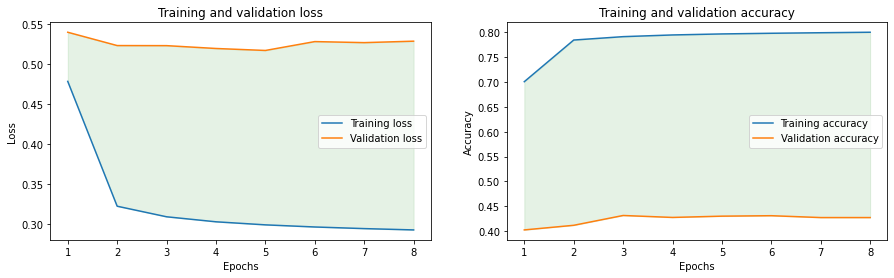

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(15,4))

ax1 = plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.fill_between(epochs, loss,val_loss,color='g',alpha=.1)

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

ax2 = plt.subplot(1, 2, 2)
plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.fill_between(epochs, acc,val_acc,color='g',alpha=.1)
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [57]:
accuracy_list = []
with tqdm(total=len(input_sequences_test_list_paded)) as pbar:
  for x_test,y_test in zip(input_sequences_test_list_paded, output_sequences_test_list_paded):
      accuracy_list.append(model.evaluate(x_test, y_test, batch_size=1024, verbose=0)[1])
      pbar.update(1)


100%|██████████| 163/163 [01:59<00:00,  1.37it/s]


In [58]:
N = 5
cumsum, moving_aves = [0], []
for i, x in enumerate(accuracy_list, 1):
    cumsum.append(cumsum[i-1] + x)
    if i >= N:
        moving_ave = (cumsum[i] - cumsum[i-N])/N
        #can do stuff with moving_ave here
        moving_aves.append(moving_ave)

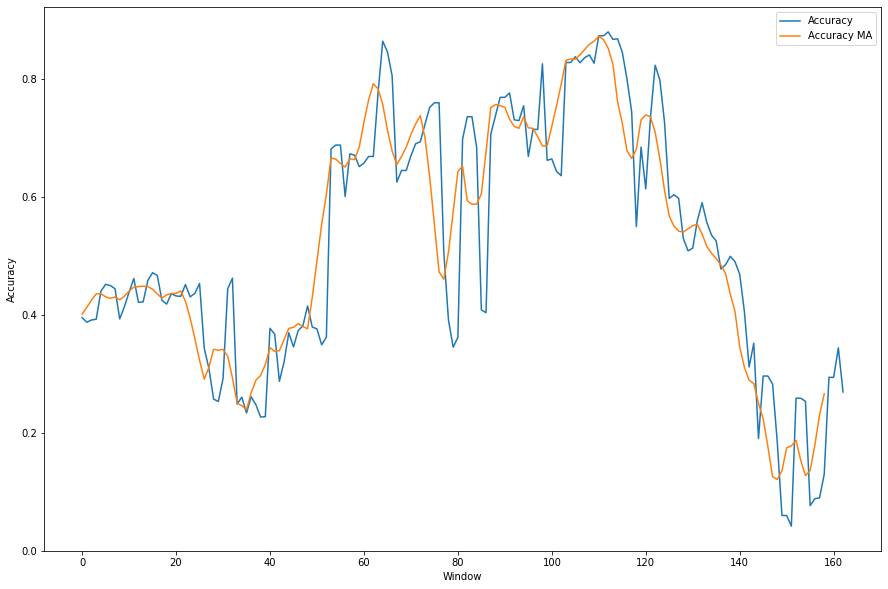

In [59]:
plt.figure(figsize=(15,10))
plt.plot(list(range(len(accuracy_list))), accuracy_list, label='Accuracy')
plt.plot(list(range(len(moving_aves))), moving_aves, label='Accuracy MA')
plt.xlabel('Window')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [60]:
for i in  range(len(input_sequences_test_list_paded)):
  print(len(input_sequences_test_list_paded[i]), ' -> ', accuracy_list[i])

4976  ->  0.3953503966331482
4255  ->  0.3875747621059418
4219  ->  0.3913200795650482
4459  ->  0.3926021456718445
6424  ->  0.4401620328426361
7310  ->  0.45182740688323975
7414  ->  0.4498162567615509
6252  ->  0.444428414106369
2741  ->  0.3931090235710144
2850  ->  0.41405412554740906
2468  ->  0.4385082721710205
3025  ->  0.4617995321750641
2900  ->  0.42109254002571106
2943  ->  0.4222206473350525
2946  ->  0.45856884121894836
2826  ->  0.4715719521045685
2738  ->  0.4669363498687744
2892  ->  0.4244832396507263
3105  ->  0.41831517219543457
2585  ->  0.4361066520214081
2456  ->  0.4320584535598755
1731  ->  0.431506872177124
1402  ->  0.45149001479148865
1603  ->  0.4305751621723175
2414  ->  0.43639007210731506
2842  ->  0.45335495471954346
14484  ->  0.3435663878917694
14026  ->  0.3087136745452881
18980  ->  0.25690433382987976
17249  ->  0.25312915444374084
8333  ->  0.2915757894515991
3804  ->  0.4443281888961792
4097  ->  0.46225789189338684
14076  ->  0.2487485259771347


In [132]:
prob_list = []
with tqdm(total=len(input_sequences_test_list_paded)) as pbar:
  for x_test,y_test in zip(input_sequences_test_list_paded, output_sequences_test_list_paded):
    dist = model.predict(x_test)
    probs = []
    for i in range(len(y_test)):
      p = 0
      for j in range(len(y_test[i])):
        if y_test[i][j] == 0:
          continue
        else:
          if not math.isnan(math.log(dist[i][j][y_test[i][j]])):
            p += math.log10(dist[i][j][y_test[i][j]])
      probs.append(p)
    prob_list.append(probs)
    
    pbar.update(1)


100%|██████████| 163/163 [13:54<00:00,  5.12s/it]


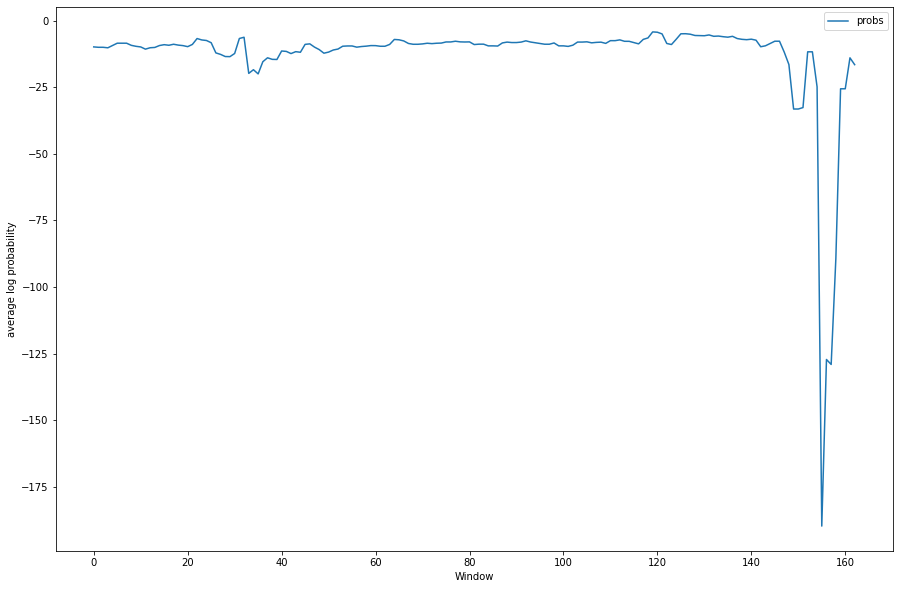

In [134]:
prob_list_avg = [np.mean(x) for x in prob_list]

plt.figure(figsize=(15,10))
plt.plot(list(range(len(prob_list_avg))), prob_list_avg, label='probs')
plt.xlabel('Window')
plt.ylabel('average log probability')
plt.legend()
plt.show()


In [120]:
x_test = np.array([0,0,0,42,1,2,3])
print('x_test> ', x_test)
y_test = np.array([2, 2, 2, 1, 2, 3, 43])
print('y_test> ', y_test)
print('-'*20)

pred_masked = np.array([np.argmax(x) for x in model.predict(x_test)])
print('pred_masked> ',pred_masked)
print('model_masked>', model.evaluate(x_test, y_test, batch_size=1024, verbose=0))
print('-'*20)
pred_unmasked = np.array([np.argmax(x) for x in model_unmasked.predict(x_test)])
print('pred_unmasked>', pred_unmasked)
print('model_unmasked>', model_unmasked.evaluate(x_test, y_test, batch_size=1024, verbose=0))


x_test>  [ 0  0  0 42  1  2  3]
y_test>  [ 2  2  2  1  2  3 43]
--------------------
pred_masked>  [6 6 6 1 2 3 4]
model_masked> [1.1486644744873047, 0.75]
--------------------
pred_unmasked> [0 0 0 1 2 3 4]
model_unmasked> [9.035201072692871, 0.4285714626312256]


In [131]:
math.log10(10)

1.0

In [135]:
prob_list[0]

[-5.450934960813145,
 -6.8438697005227285,
 -6.346931428443098,
 -7.8666293020624405,
 -9.405523003563877,
 -9.5482092275529,
 -5.450934960813145,
 -6.8438697005227285,
 -6.346931428443098,
 -4.6035738616409905,
 -5.2437616243594665,
 -5.617403323619783,
 -5.450934960813145,
 -6.8438697005227285,
 -6.346931428443098,
 -6.325999248967491,
 -8.069483220782697,
 -8.19179577233176,
 -8.651823013867077,
 -8.517934263493743,
 -9.308341119156157,
 -9.462357952772724,
 -10.36183274690757,
 -10.837378585050619,
 -10.97202684098723,
 -10.6768740749391,
 -11.682756713277364,
 -12.259937054805263,
 -12.420481211774549,
 -5.450934960813145,
 -6.8438697005227285,
 -6.346931428443098,
 -7.155480138355737,
 -4.6035738616409905,
 -5.450934960813145,
 -6.8438697005227285,
 -6.346931428443098,
 -7.155480138355737,
 -7.639621555429587,
 -8.477011090362348,
 -8.844356180670394,
 -9.391650200991654,
 -8.992116401329618,
 -9.19748672703644,
 -9.68973688548204,
 -10.052797359283323,
 -10.73056791787861,
 -11.